In this notebook, we explore the number of case and sanction amount overtime.  
- First we will focus on explore number of case over time.  
- Total $ on sanction over time.  
- Top company in term of cases number and $

In [214]:
#import libary and configure
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Confgure
# Path to data
PATH_TO_DATA = "../data/processed/faa_enforcement_final_cleaned.csv"
# Size of plots
plt.rcParams['figure.figsize'] = (10, 5)

In [215]:
df = pd.read_csv(PATH_TO_DATA, parse_dates=["DATE KNOWN", "CLOSED DATE"])
df.head()


,CASE NUMBER,NAME,ENTITY TYPE,DATE KNOWN,ACTION,SANCTION AMOUNT,SANCTION,CASE TYPE,CLOSED DATE
0,2008GL070135,CRUCIAL AIR SUPPORT LLC,APPROVD REPAIR STA,2008-09-22,ORD ASSESS CIVIL PENALTY,1000.0,DOLLARS,MAINTENANCE,2010-01-04
1,2007WP190107,PRIMARIS AIRLINES INC,A/C or COMM OPER,2007-07-10,ORD ASSESS CIVIL PENALTY,NaN,SANCTION WAIVED,RECORDS/RPTS,2010-01-04
2,2006WP700166,MESA AIRLINES INC,A/C or COMM OPER,2006-06-19,ORD ASSESS CP HMT,55000.0,DOLLARS,HAZ MAT,2010-01-05
3,2007WP700017,MESA AIRLINES INC,A/C or COMM OPER,2006-10-18,ORD ASSESS CP HMT,60000.0,DOLLARS,HAZ MAT,2010-01-05
4,2008SO950034,PACIFIC WINGS L L C,A/C or COMM OPER,2007-10-31,ORD ASSESS CIVIL PENALTY,10000.0,DOLLARS,DRUG TESTING,2010-01-07


<Axes: title={'center': 'Industry Cases Over Time'}, xlabel='DATE KNOWN', ylabel='Number of Cases'>

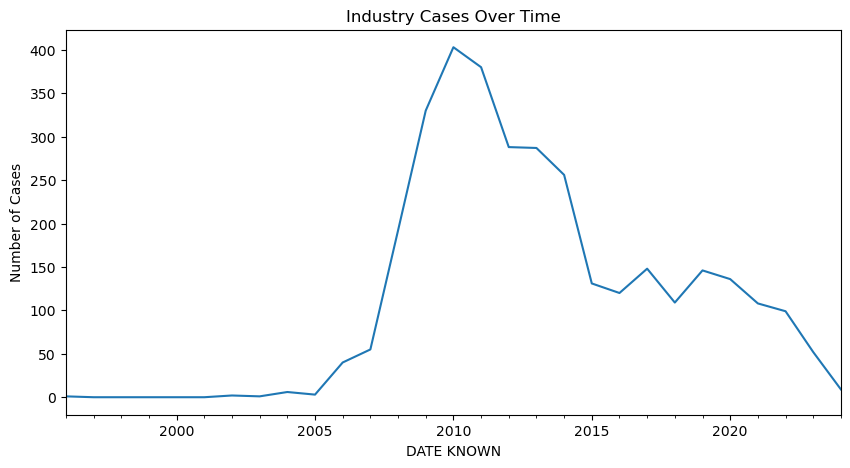

In [216]:

#Case over time
cases_ts = (df.set_index('DATE KNOWN')
              .assign(_=1)['_']
              .resample('Y').sum())

cases_ts.plot(title='Industry Cases Over Time', ylabel='Number of Cases')

<Axes: title={'center': 'Total Sanctions Over Time (Millions)'}, xlabel='DATE KNOWN', ylabel='Sanctions (M USD)'>

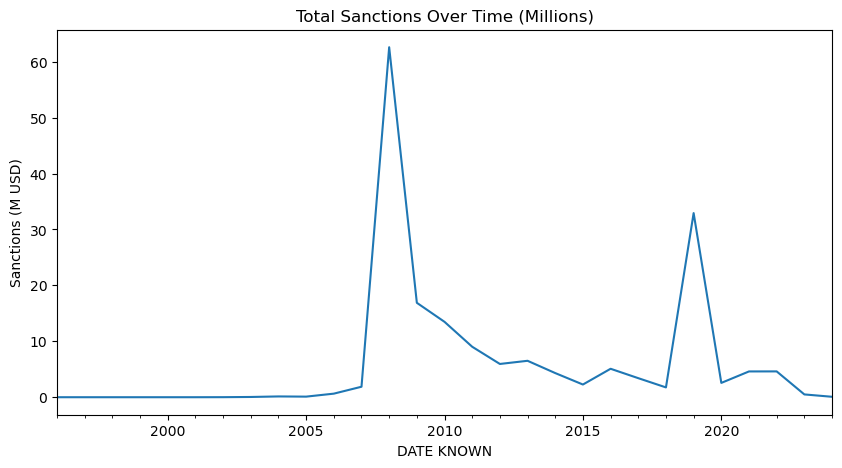

In [217]:
df['SANCTION AMOUNT'] = pd.to_numeric(df['SANCTION AMOUNT']
                                      .astype(str).str.replace(',', ''),
                                      errors='coerce')
sanctions_ts = (df.set_index('DATE KNOWN')['SANCTION AMOUNT']
                  .resample('Y').sum()) / 1_000_000

sanctions_ts.plot(title='Total Sanctions Over Time (Millions)',
                  ylabel='Sanctions (M USD)')


Revocation cases: 242


<Axes: title={'center': 'Revocation Cases Over Time'}, xlabel='DATE KNOWN', ylabel='Number of Revocations'>

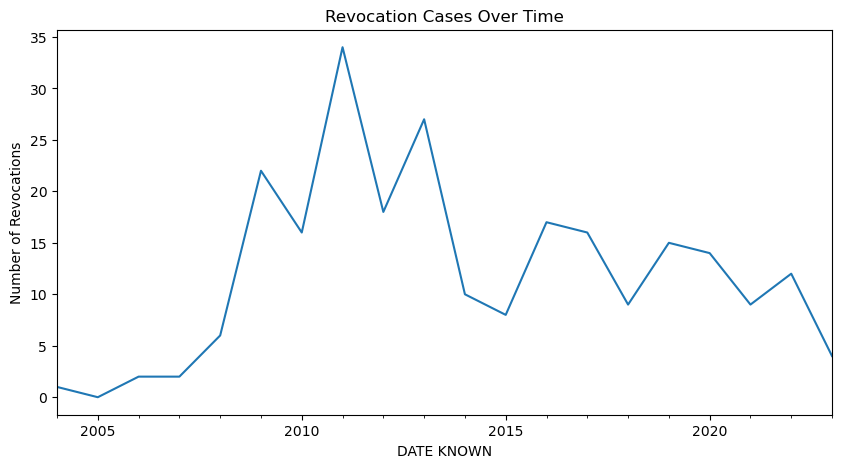

In [218]:
df_revoke = df[df['SANCTION'] == 'REVOCATION']
print("Revocation cases:", len(df_revoke))
df_revoke.head()

revoke_cases = (df_revoke.set_index('DATE KNOWN')
                              .assign(_=1)['_']
                              .resample('Y').sum())

revoke_cases.plot(title='Revocation Cases Over Time',
                  ylabel='Number of Revocations')


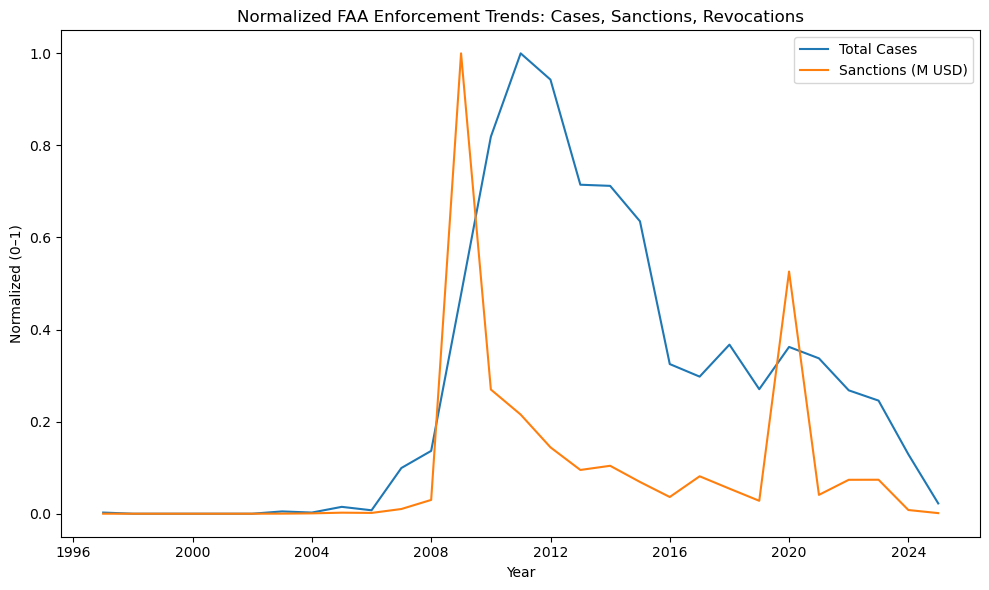

<Figure size 1000x500 with 0 Axes>

In [ ]:
#Putting all tree graph together to see the all the trends in one
# --- 1. Total cases per year ---
all_cases = (df.set_index('DATE KNOWN')
               .assign(_=1)['_']
               .resample('Y').sum())

# --- 2. Sanctions amount per year (millions) ---
df['SANCTION AMOUNT'] = pd.to_numeric(df['SANCTION AMOUNT'].astype(str).str.replace(',', ''), errors='coerce')
sanctions = (df.set_index('DATE KNOWN')['SANCTION AMOUNT']
               .resample('Y').sum()) / 1_000_000

# --- 3. Revocations per year ---
#df_revoke = df[df['SANCTION'] == 'REVOCATION']
#revoke_cases = (df_revoke.set_index('DATE KNOWN')
#                              .assign(_=1)['_']
#                              .resample('Y').sum())

# --- 4. Combine into one dataframe ---
df_combo = pd.DataFrame({
    'Total Cases': all_cases,
    'Sanctions (M USD)': sanctions,
    #'Revocations': revoke_cases
}).fillna(0)

# --- 5. Normalize each series (0–1) ---
df_norm = df_combo.divide(df_combo.max())

# --- 6. Plot trends ---
plt.figure(figsize=(10,6))
for col in df_norm.columns:
    plt.plot(df_norm.index, df_norm[col], label=col)

plt.title('Normalized FAA Enforcement Trends: Cases, Sanctions, Revocations')
plt.xlabel('Year')
plt.ylabel('Normalized (0–1)')
plt.legend()
plt.tight_layout()
plt.savefig("../charts/normalized_trend.png")
plt.show()



In [220]:
# Count total cases per company
cases_by_company = df['NAME'].value_counts().head(10)

print("Top 10 companies by number of cases:")
print(cases_by_company)


Top 10 companies by number of cases:
NAME
FEDERAL EXPRESS CORP            94
AMERICAN AIRLINES INC           85
AMERICAN EAGLE AIRLINES, INC    49
UNITED PARCEL SERVICE CO        49
AVANTAIR INC                    48
SOUTHWEST AIRLINES CO           29
SKYWEST AIRLINES INC            28
US AIRWAYS INC                  25
AMERICAN EAGLE AIRLINES INC     25
UNITED AIR LINES INC            24
Name: count, dtype: int64


In [221]:
# 1. Total sanctions ($) by company
sanctions_by_company = (
    df.groupby("NAME")["SANCTION AMOUNT"]
      .sum()
      .sort_values(ascending=False)
)

# Show top 10
print(sanctions_by_company.head(10))


NAME
US AIRWAYS INC                 27622500.0
THE BOEING COMPANY             27178778.0
AMERICAN AIRLINES INC          24373750.0
SOUTHWEST AIRLINES CO           9311000.0
UNITED AIR LINES INC            4959347.0
FEDERAL EXPRESS CORP            4909025.0
NAVWORX INC                     3685000.0
BOEING COMMERCIAL AIRPLANES     3550000.0
AERO MICRONESIA INC             2908850.0
ALASKA AIRLINES INC             2580767.0
Name: SANCTION AMOUNT, dtype: float64


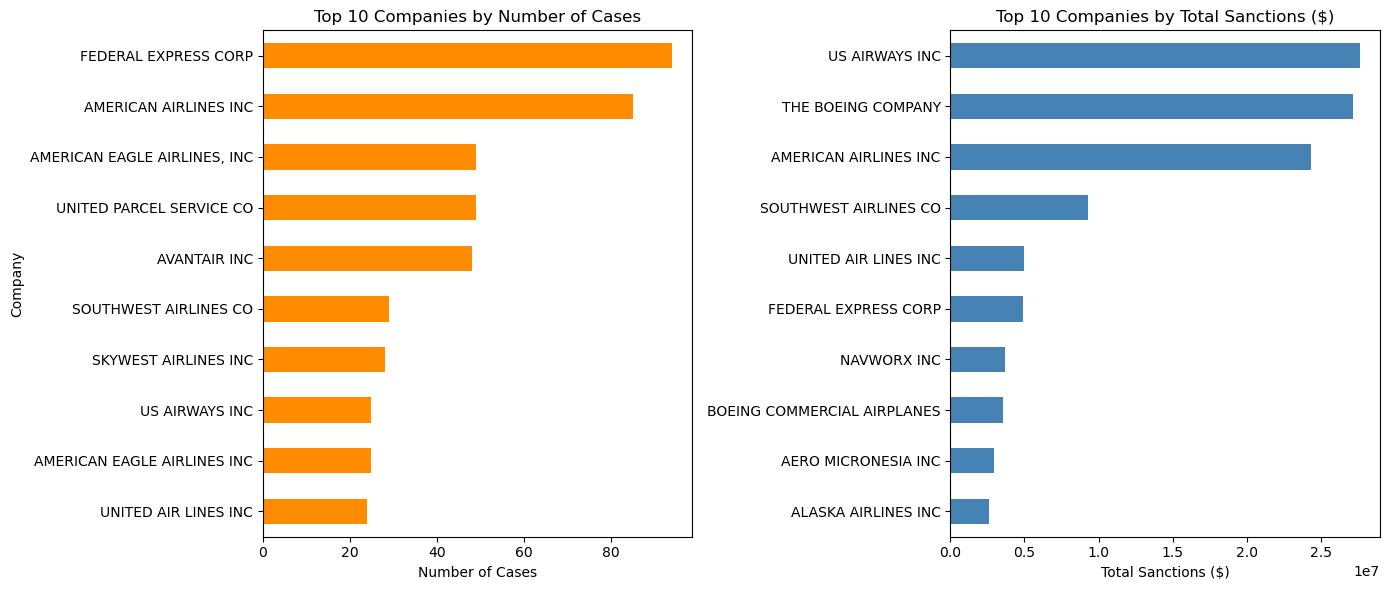

<Figure size 1000x500 with 0 Axes>

In [ ]:
# Prepare data
top_cases = (
    df.groupby("NAME")["CASE NUMBER"]
      .count()
      .sort_values(ascending=False)
      .head(10)
)

top_sanctions = sanctions_by_company.head(10)

# Side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Left: Number of Cases
top_cases.sort_values().plot(
    kind="barh", ax=axes[0], color="darkorange"
)
axes[0].set_title("Top 10 Companies by Number of Cases")
axes[0].set_xlabel("Number of Cases")
axes[0].set_ylabel("Company")

# Right: Total Sanctions
top_sanctions.sort_values().plot(
    kind="barh", ax=axes[1], color="steelblue"
)
axes[1].set_title("Top 10 Companies by Total Sanctions ($)")
axes[1].set_xlabel("Total Sanctions ($)")
axes[1].set_ylabel("")

plt.tight_layout()
plt.savefig("../charts/top_10_in_number_case_and_sanctions.png")
plt.show()



A few things noticeable that can investigate further
1. High case count ≠ High sanction cost: FedEx is top the number of cases chart, but only small amount of Sanctions compare to the case.
    (FedEx had the most cases but relatively small dollar sanctions per case.)

2. Boeing’s anomaly

    Boeing doesn’t even appear in the top 10 by number of cases, yet is #2 in total sanctions.

    That means Boeing’s average sanction per case is very high compared to peers — fewer cases, but each is much more costly

Let's explore further into Boeing case.

In [223]:
boeing_cases = df[df["NAME"].str.contains("BOEING", case=False)]
boeing_cases[["CASE NUMBER", "DATE KNOWN", "CASE TYPE", "SANCTION AMOUNT", "SANCTION", "ACTION"]]


,CASE NUMBER,DATE KNOWN,CASE TYPE,SANCTION AMOUNT,SANCTION,ACTION
1070,2010NM410012,2010-03-15,QUAL CONTROL,800000.0,DOLLARS,CIVIL PENALTY
1399,2010NM410014,2010-04-23,QUAL CONTROL,2750000.0,DOLLARS,CIVIL PENALTY
1400,2011NM520003,2011-02-14,OTHER,NaN,CONSOLIDATED CASE,CIVIL PENALTY
1401,2012NM520006,2011-01-05,OTHER,NaN,CONSOLIDATED CASE,CIVIL PENALTY
1402,2012NM410009,2012-03-14,QUAL CONTROL,NaN,CONSOLIDATED CASE,CIVIL PENALTY
1403,2012NM520035,2012-05-31,OTHER,NaN,CONSOLIDATED CASE,CIVIL PENALTY
1404,2012NM520057,2012-06-13,OTHER,NaN,CONSOLIDATED CASE,CIVIL PENALTY
1405,2013NM410009,2011-11-09,QUAL CONTROL,NaN,CONSOLIDATED CASE,CIVIL PENALTY
1406,2013NM410010,2011-11-07,QUAL CONTROL,NaN,CONSOLIDATED CASE,CIVIL PENALTY
1407,2013NM410018,2012-08-08,QUAL CONTROL,NaN,CONSOLIDATED CASE,CIVIL PENALTY


In [224]:
print("Total sanctions ($):", boeing_cases["SANCTION AMOUNT"].sum())
print("Average sanction per case ($):", boeing_cases["SANCTION AMOUNT"].mean())
print("Number of Boeing cases:", boeing_cases.shape[0])

Total sanctions ($): 30728778.0
Average sanction per case ($): 10242926.0
Number of Boeing cases: 21


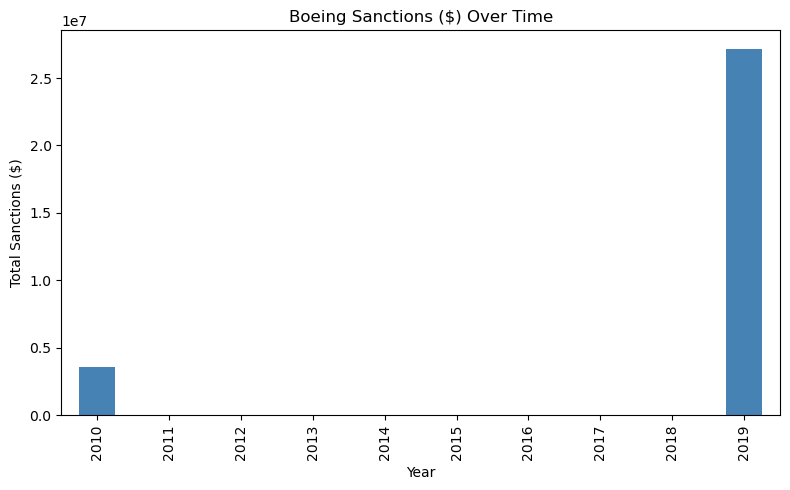

In [225]:
boeing_trend = (
    boeing_cases
    .set_index("DATE KNOWN")
    .resample("Y")["SANCTION AMOUNT"]
    .sum()
)

# Convert index to year only
boeing_trend.index = boeing_trend.index.year

# Plot again
plt.figure(figsize=(8,5))
boeing_trend.plot(kind="bar", color="steelblue")

plt.title("Boeing Sanctions ($) Over Time")
plt.ylabel("Total Sanctions ($)")
plt.xlabel("Year")
plt.tight_layout()
plt.savefig("../charts/boeing_sanctions_over_time.png")
plt.show()



In [226]:
boeing_cases = df[df["NAME"].str.contains("BOEING", case=False, na=False)]

# Focus on 2010 and 2019
boeing_2010 = boeing_cases[boeing_cases["DATE KNOWN"].dt.year == 2010]
boeing_2019 = boeing_cases[boeing_cases["DATE KNOWN"].dt.year == 2019]

print("Boeing cases 2010:", boeing_2010.shape[0])
print("Boeing cases 2019:", boeing_2019.shape[0])

# Peek into details
display(boeing_2010)
display(boeing_2019)


Boeing cases 2010: 2
Boeing cases 2019: 7


,CASE NUMBER,NAME,ENTITY TYPE,DATE KNOWN,ACTION,SANCTION AMOUNT,SANCTION,CASE TYPE,CLOSED DATE
1070,2010NM410012,BOEING COMMERCIAL AIRPLANES,AIRCRAFT PROD,2010-03-15,CIVIL PENALTY,800000.0,DOLLARS,QUAL CONTROL,2012-05-18
1399,2010NM410014,BOEING COMMERCIAL AIRPLANES,AIRCRAFT PROD,2010-04-23,CIVIL PENALTY,2750000.0,DOLLARS,QUAL CONTROL,2016-06-23


,CASE NUMBER,NAME,ENTITY TYPE,DATE KNOWN,ACTION,SANCTION AMOUNT,SANCTION,CASE TYPE,CLOSED DATE
1629,2019NM410003,THE BOEING COMPANY,AIRCRAFT PROD,2019-06-07,CIVIL PENALTY,27178778.0,DOLLARS,QUAL CONTROL,2021-05-26
1630,2019NM420003,THE BOEING COMPANY,AIRCRAFT PROD,2019-03-20,CIVIL PENALTY,NaN,CONSOLIDATED CASE,OTHER,2021-05-26
1631,2020NM410001,THE BOEING COMPANY,AIRCRAFT PROD,2019-06-07,CIVIL PENALTY,NaN,CONSOLIDATED CASE,QUAL CONTROL,2021-05-26
2514,2019NM410003,THE BOEING COMPANY,AIRCRAFT PROD,2019-06-07,CIVIL PENALTY,NaN,DOLLARS,QUAL CONTROL,2022-08-23
2515,2019NM410003,THE BOEING COMPANY,AIRCRAFT PROD,2019-06-07,CIVIL PENALTY,NaN,SANCTION WAIVED,QUAL CONTROL,2022-08-23
2516,2019NM420003,THE BOEING COMPANY,AIRCRAFT PROD,2019-03-20,CIVIL PENALTY,NaN,CONSOLIDATED CASE,OTHER,2022-08-23
2517,2020NM410001,THE BOEING COMPANY,AIRCRAFT PROD,2019-06-07,CIVIL PENALTY,NaN,CONSOLIDATED CASE,QUAL CONTROL,2022-08-23


Based on the table 